In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sn
from netCDF4 import Dataset
from google.colab import files
import matplotlib.pyplot as plt
from sklearn import linear_model
from keras.models import Sequential, Model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers import Dense, Dropout, Flatten, Activation, Input, LSTM, GRU, Multiply, Add, SimpleRNN
from sklearn.metrics import r2_score

## Load and split dataset

In [2]:
files.upload()
nc = Dataset('tempStJohns.nc')

Saving tempStJohns.nc to tempStJohns (5).nc


In [3]:
temp = nc['t2m'][:,0,0,0] - 273.15

In [4]:
values= temp.data
values = values.reshape((len(values), 1))
# train the normalization
scaler = StandardScaler()
normalized = scaler.fit_transform(values)

# # inverse transform and print the first 5 rows
# inversed = scaler.inverse_transform(normalized)

In [5]:
def split_dataset(x_len, y_len, data):
  X, Y = [],[]
  record_num = data.shape[0]//(x_len + y_len)
  for i in range(record_num):
    X.append([x[0] for x in data[i:i+x_len]])
    Y.append([x[0] for x in data[i+x_len:i+x_len+y_len]])
  return pd.DataFrame(X), pd.DataFrame(Y)

feature, target = split_dataset(6, 6, normalized)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, shuffle=True)

In [7]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [66]:
preds = []
times = []

# Q1

## Linear regression

In [67]:
start = time.time()
model_lr = linear_model.LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
stop = time.time()
times.append(stop-start)
preds.append(y_pred_lr)
for i in range(6):
  print('%d-th R2-score: %.2f' % (i, r2_score(y_test[i], y_pred_lr[:,i])))

0-th R2-score: 0.99
1-th R2-score: 0.98
2-th R2-score: 0.97
3-th R2-score: 0.95
4-th R2-score: 0.93
5-th R2-score: 0.91


## MLP

In [76]:
model_mlp = Sequential()
model_mlp.add(Dense(512, input_shape=(6,), activation='relu'))
model_mlp.add(Dense(512, activation='relu'))
model_mlp.add(Dense(6))

model_mlp.compile(loss='mse', optimizer='adam', metrics=['mse'])
model_mlp.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               3584      
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dense_8 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 269,318
Trainable params: 269,318
Non-trainable params: 0
_________________________________________________________________


In [77]:
start = time.time()
history_mlp = model_mlp.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_test, y_test))
stop = time.time()
times.append(stop-start)

Epoch 1/40
183/183 [==============================] - 2s 7ms/step - loss: 1.2242e-04 - mse: 1.2242e-04 - val_loss: 9.7891e-07 - val_mse: 9.7891e-07
Epoch 2/40
183/183 [==============================] - 1s 6ms/step - loss: 9.3254e-07 - mse: 9.3254e-07 - val_loss: 1.0232e-06 - val_mse: 1.0232e-06
Epoch 3/40
183/183 [==============================] - 1s 6ms/step - loss: 8.7155e-07 - mse: 8.7155e-07 - val_loss: 8.5842e-07 - val_mse: 8.5842e-07
Epoch 4/40
183/183 [==============================] - 1s 6ms/step - loss: 8.4404e-07 - mse: 8.4404e-07 - val_loss: 8.5206e-07 - val_mse: 8.5206e-07
Epoch 5/40
183/183 [==============================] - 1s 6ms/step - loss: 7.5095e-07 - mse: 7.5095e-07 - val_loss: 7.6278e-07 - val_mse: 7.6278e-07
Epoch 6/40
183/183 [==============================] - 1s 6ms/step - loss: 6.9493e-07 - mse: 6.9493e-07 - val_loss: 6.4422e-07 - val_mse: 6.4422e-07
Epoch 7/40
183/183 [==============================] - 1s 6ms/step - loss: 6.5673e-07 - mse: 6.5673e-07 - val_los

In [78]:
y_pred_mlp = model_mlp.predict(X_test)
preds.append(y_pred_mlp)
for i in range(6):
  print('%d-th R2-score: %.2f' % (i, r2_score(y_test[i], y_pred_mlp[:,i])))

0-th R2-score: 0.90
1-th R2-score: 0.74
2-th R2-score: 0.80
3-th R2-score: 0.84
4-th R2-score: 0.77
5-th R2-score: 0.77


## RNN

In [79]:
rnn_models = []
input = Input(shape=(6,1))

#LSTM
x_lstm = LSTM(units= 128, return_sequences=True)(input)
x_lstm = LSTM(units= 128)(x_lstm)
x_lstm = Dense(units = 6)(x_lstm)

rnn_models.append(Model(input, x_lstm))

#GRU
x_gru = GRU(units= 128, return_sequences=True)(input)
x_gru = GRU(units= 128)(x_gru)
x_gru = Dense(units = 6)(x_gru)

rnn_models.append(Model(input, x_gru))

#simple rnn
x_rnn = SimpleRNN(units= 128, return_sequences=True)(input)
x_rnn = SimpleRNN(units= 128)(x_rnn)
x_rnn = Dense(units = 6)(x_rnn)

rnn_models.append(Model(input, x_rnn))

In [80]:
for model in rnn_models:
  
  model.compile(loss='mse', optimizer='adam', metrics=['mse'])
  model.summary()

  start = time.time()
  model.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_test, y_test))
  stop = time.time()
  times.append(stop-start)

  y_pred = model.predict(X_test)
  preds.append(y_pred)
  for i in range(6):
    print('%d-th R2-score: %.2f' % (i, r2_score(y_test[i], y_pred[:,i])))

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 6, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 6, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_9 (Dense)             (None, 6)                 774       
                                                                 
Total params: 198,918
Trainable params: 198,918
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
183/183 [==============================] - 14s 21ms/step - loss: 1.9243e-04 - mse: 1.9243e-04 - val_loss: 3.3682e-06 - val_mse: 3.3682e-06
Epoch 2/40
183/183 [==============

# Q2

In [160]:
def residual_block(x, n_filter, dilation):
  original_x = x
  
  sig = Conv1D(n_filter, 3, dilation_rate=dilation, padding='same', use_bias=False, activation="sigmoid")(x)
  tanh = Conv1D(n_filter, 3, dilation_rate=dilation, padding='same', use_bias=False, activation="tanh")(x)
  x = Multiply()([tanh, sig])
  x = Conv1D(n_filter, 1, padding='same', use_bias=False)(x)
  skip_x = x
  x = Add()([original_x, x])

  return x, skip_x

In [180]:
def WaveNet(input_shape, n_stack, n_filter, dilation_lim):
  input = Input(shape=input_shape)
  skip_connections = []
  x = Conv1D(n_filter, 3, padding='causal', strides=1)(input)

  for _ in range(n_stack):
    for i in range(0, dilation_lim):
      dilation = 2**i
      x, skip_x = residual_block(x, n_filter, dilation)
      skip_connections.append(skip_x)

  x = Add()(skip_connections)
  x_1 = Activation('relu')(x)
  x_2 = Conv1D(n_filter, 1, padding='same')(x_1)
  x_3 = Activation('relu')(x_2)
  x_4 = Conv1D(1, 1, padding='same')(x_3)
  x = x_4[:,-6:,:]

  return input, x

In [181]:
input, out = WaveNet((6, 1) , 1, 64, 5)
model = Model(input, out)
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.summary()

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 6, 1)]       0           []                               
                                                                                                  
 conv1d_1694 (Conv1D)           (None, 6, 64)        256         ['input_30[0][0]']               
                                                                                                  
 conv1d_1696 (Conv1D)           (None, 6, 64)        12288       ['conv1d_1694[0][0]']            
                                                                                                  
 conv1d_1695 (Conv1D)           (None, 6, 64)        12288       ['conv1d_1694[0][0]']            
                                                                                           

In [182]:
start = time.time()
history = model.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_test, y_test))
stop = time.time()
times.append(stop-start)

Epoch 1/40
183/183 [==============================] - 5s 20ms/step - loss: 1.9490e-04 - mse: 1.9490e-04 - val_loss: 1.8700e-06 - val_mse: 1.8700e-06
Epoch 2/40
183/183 [==============================] - 3s 18ms/step - loss: 1.6653e-06 - mse: 1.6653e-06 - val_loss: 1.5784e-06 - val_mse: 1.5784e-06
Epoch 3/40
183/183 [==============================] - 3s 18ms/step - loss: 1.4307e-06 - mse: 1.4307e-06 - val_loss: 1.2623e-06 - val_mse: 1.2623e-06
Epoch 4/40
183/183 [==============================] - 3s 18ms/step - loss: 1.1730e-06 - mse: 1.1730e-06 - val_loss: 1.2345e-06 - val_mse: 1.2345e-06
Epoch 5/40
183/183 [==============================] - 3s 18ms/step - loss: 9.3639e-07 - mse: 9.3639e-07 - val_loss: 1.0360e-06 - val_mse: 1.0360e-06
Epoch 6/40
183/183 [==============================] - 3s 18ms/step - loss: 1.0966e-06 - mse: 1.0966e-06 - val_loss: 1.6853e-06 - val_mse: 1.6853e-06
Epoch 7/40
183/183 [==============================] - 3s 18ms/step - loss: 8.1943e-07 - mse: 8.1943e-07 - 

In [191]:
y_pred = model.predict(X_test).reshape(X_test.shape[0], 6)
preds.append(y_pred)
for i in range(6):
  print('%d-th R2-score: %.2f' % (i, r2_score(y_test[i], y_pred[:,i])))

0-th R2-score: 0.92
1-th R2-score: 0.92
2-th R2-score: 0.85
3-th R2-score: 0.85
4-th R2-score: 0.85
5-th R2-score: 0.84


# Compare Models

Accuracy

(1462, 6)
(1462, 6)
(1462, 6)
(1462, 6)
(1462, 6)
(1462, 6)


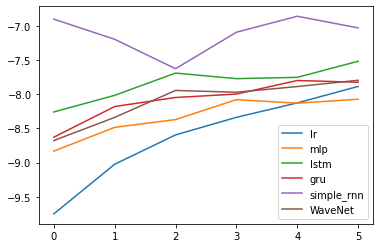

In [193]:
for pred in preds:
  print(pred.shape)
  m = np.log(y_test - pred).mean(axis=0)
  plt.plot(m)
lables = ['lr','mlp', 'lstm', 'gru', 'simple_rnn', 'WaveNet']
plt.legend(lables)
plt.show()

R2 Score

In [194]:
for i in range(len(lables)):
  print(lables[i])
  pred = preds[i]
  for j in range(6):
    print('%d-th R2-score: %.2f' % (j, r2_score(y_test[i], y_pred[:,j])))

lr
0-th R2-score: 0.92
1-th R2-score: 0.93
2-th R2-score: 0.89
3-th R2-score: 0.91
4-th R2-score: 0.92
5-th R2-score: 0.93
mlp
0-th R2-score: 0.91
1-th R2-score: 0.92
2-th R2-score: 0.87
3-th R2-score: 0.89
4-th R2-score: 0.90
5-th R2-score: 0.91
lstm
0-th R2-score: 0.89
1-th R2-score: 0.90
2-th R2-score: 0.85
3-th R2-score: 0.87
4-th R2-score: 0.88
5-th R2-score: 0.90
gru
0-th R2-score: 0.87
1-th R2-score: 0.88
2-th R2-score: 0.83
3-th R2-score: 0.85
4-th R2-score: 0.86
5-th R2-score: 0.88
simple_rnn
0-th R2-score: 0.85
1-th R2-score: 0.86
2-th R2-score: 0.81
3-th R2-score: 0.84
4-th R2-score: 0.85
5-th R2-score: 0.86
WaveNet
0-th R2-score: 0.84
1-th R2-score: 0.84
2-th R2-score: 0.80
3-th R2-score: 0.82
4-th R2-score: 0.83
5-th R2-score: 0.84


Time

In [195]:
for i in range(len(lables)):
  print(lables[i], "=", times[i])

lr = 0.016170501708984375
mlp = 82.372230052948
lstm = 152.00494980812073
gru = 144.92892837524414
simple_rnn = 52.336358070373535
WaveNet = 123.21418857574463
